# Exercise 10.1
## Signal Classification using Dynamic Graph Convolutional Neural Networks+
After a long journey through the universe before reaching the earth, the cosmic particles interact with the galactic magnetic field $B$.
As these particles carry a charge $q$ they are deflected in the field by the Lorentz force $F = q \cdot v × B$.
Sources of cosmic particles are located all over the sky, thus arrival distributions of the cosmic particles are isotropic in general. However, particles originating from the same source generate on top of the isotropic
arrival directions, street-like patterns from galactic magnetic field deflections.

In this tasks we want to classify whether a simulated set of $500$ arriving cosmic particles contains street-like patterns (signal), or originates from an isotropic background.

Training graph networks can be computationally demanding, thus, we recommend to use a GPU for this task.

In [3]:
from tensorflow import keras
import numpy as np
import healpy
from matplotlib import pyplot as plt

layers = keras.layers

print("keras", keras.__version__)

keras 2.4.0


#### Download EdgeConv Layer

In [4]:
import gdown
import os

url = "https://github.com/DeepLearningForPhysicsResearchBook/deep-learning-physics/blob/main/edgeconv.py"
output = 'edgeconv.py'

if os.path.exists(output) == False:
    gdown.download(url, output, quiet=False)

from edgeconv import EdgeConv

### Download Data

In [5]:
url = "https://drive.google.com/u/0/uc?export=download&confirm=HgGH&id=1XKN-Ik7BDyMWdQ230zWS2bNxXL3_9jZq"
output = 'cr_sphere.npz'

if os.path.exists(output) == False:
    gdown.download(url, output, quiet=True)

In [6]:
f = np.load(output)
n_train = 10000
x_train, x_test = f['data'][:-n_train], f['data'][-n_train:]
labels = keras.utils.to_categorical(f['label'], num_classes=2)
y_train, y_test = labels[:-n_train], labels[-n_train:]

In [7]:
print("x_train.shape", x_train.shape)
print("y_train.shape", y_train.shape)

x_train.shape (40000, 500, 4)
y_train.shape (40000, 2)


In [8]:
# define coordinates for very first EdgeConv
train_points, test_points = x_train[..., :3], x_test[..., :3]

# Use normalized Energy as features for convolutional layers
train_features, test_features = x_train[..., -1, np.newaxis], x_test[..., -1, np.newaxis]
train_features = np.concatenate([train_features, train_points], axis=-1)

train_input_data = [train_points, train_features]
test_input_data = [test_points, test_features]

### Plot an example sky map

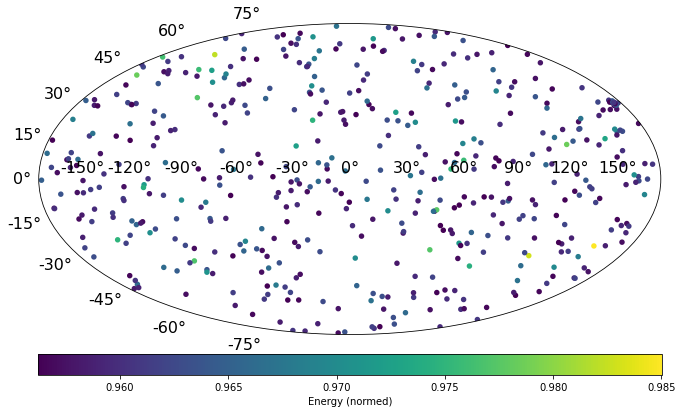

In [9]:
def scatter(v, c=None, zlabel="", title="", **kwargs):

    def vec2ang(v):
        x, y, z = np.asarray(v)
        phi = np.arctan2(y, x)
        theta = np.arctan2(z, (x * x + y * y) ** .5)
        return phi, theta

    lons, lats = vec2ang(v)
    lons = -lons
    fig = plt.figure(figsize=kwargs.pop('figsize', [12, 6]))
    ax = fig.add_axes([0.1, 0.1, 0.85, 0.9], projection="hammer")
    events = ax.scatter(lons, lats, c=c, s=12, lw=2)

    cbar = plt.colorbar(events, orientation='horizontal', shrink=0.85, pad=0.05, aspect=30, label=zlabel)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    return fig


test_id = 0
example_map = x_test[test_id]
fig = scatter(example_map[:, 0:3].T, c=example_map[:, 3], zlabel="Energy (normed)", title = "Event %i" % test_id)

### Design DGCNN

#### Start with defining a kernel network
Design a kernel network. The input to the kernel network is the central pixel coordinate and the neighborhood pixel coordinates.
Hint: using `layers.BatchNormalization` can help to stabilize the training process of a DGCNN.

You can make use of the code snippet below.

Note that the output of the DNN should be `(None, nodes)`, where `None` is a placeholder for the batch size.

In [ ]:
def kernel_nn(data, nodes=16):
    d1, d2 = data  # get xi ("central" pixel) and xj ("neighborhood" pixels)

    return x

#### Build complete graph network model
In the first layer, it might be advantageous to choose the next neighbors using the coordinates of the cosmic ray but perform the convolution using their energies also.
Thus, we input `y = EdgeConv(...)[points_input, feats_input]` into the first EdgeConv layer.  
If we later want to perform a dynamic EdgeConv (we want to update the graph), we simply input `z = EdgeConv(...)([y, y])`.

To specify the size of the "convolutional filter", make use of the `next_neighbors` argument (searches for $k$ next neighbors for each cosmic ray). 

In [ ]:
points_input = layers.Input((500, 3))
feats_input = layers.Input((500, 4))

x = EdgeConv(lambda a: kernel_nn(a, nodes=8), next_neighbors=5)([points_input, feats_input])  # conv with fixed graph
x = layers.Activation("relu")(x)
...
out = layers.Dense(2, name="classification", activation="softmax")(x)

model = keras.models.Model([points_input, feats_input], out)
print(model.summary())

You can inspect the kernel network using:

In [ ]:
model.layers[2].kernel_func.summary()

### Train the model

In [ ]:
model.compile(...)

In [ ]:
history = model.fit(train_input_data, y_train, batch_size=64, epochs=10)

## Visualization of the underlying graph
To inspect the changing neighborhood relation (we used a DGCNN) of the nodes, we visualize the underlying graph structure.

Note that plotting may take some time, so be a bit patient.

To perform the relative complex plotting, we make use of networkx and sklearn.  
If you don't have installed the packages yet, run the cell below.

In [ ]:
import sys
!{sys.executable} -m pip install sklearn
!{sys.executable} -m pip install networkx

In [ ]:
import tensorflow.keras.backend as K
from sklearn.neighbors import kneighbors_graph
import networkx as nx

edge_layers = [l for l in model.layers if "edge_conv" in l.name]
coord_mask = [np.sum(np.linalg.norm(inp_d[test_id], axis=-1)) == 500 for inp_d in train_input_data]
assert True in coord_mask, "For plotting the spherical graph at least one input has to have 3 dimensions XYZ"
fig, axes = plt.subplots(ncols=len(edge_layers), figsize=(5 * len(edge_layers), 5))

for i, e_layer in enumerate(edge_layers):
    points_in, feats_in = model.inputs
    coordinates = e_layer.get_input_at(0)
    functor = K.function(model.inputs, coordinates)
    sample_input = [inp[np.newaxis, test_id] for inp in train_input_data]

    if type(e_layer.input) == list:
        layer_points, layer_features = functor(sample_input)
    else:
        layer_points = functor(sample_input)

    layer_points = np.squeeze(layer_points)
    adj = kneighbors_graph(layer_points, e_layer.next_neighbors)
    g = nx.DiGraph(adj)

    for c, s in zip(coord_mask, sample_input):
        if c == True:
            pos = s
            break

    axes[i].set_title("Graph in %s" % e_layer.name)
    nx.draw(g, cmap=plt.get_cmap('viridis'), pos=pos.squeeze()[:, :-1],
            node_size=10, width=0.5, arrowsize=5, ax=axes[i])
    axes[i].axis('equal')